In [37]:
# Importing necessary libraries
import torch
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import util
from sentence_transformers import util
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2' ,device="cuda")
# ** Use any model of your liking for creating word embedding, The versatile SentenceTransformer model provided by sbert is adept at generating word embeddings, capable of capturing semantic representations for both isolated words and complete sentences.
# ** For utlizing spaCy embeddings use :
"""
    embedding = nlp(word).vector

"""
# ** For utlizing gensim Word2Vec embedding use :

"""
    # (Recommended Gensim version ; 3.8.2)
    import gensim.downloader as api
    model = api.load("glove-wiki-gigaword-200)
    if word in self._model.index_to_key:
        embedding = self._model[word]

"""

nlp = spacy.load("en_core_web_md")

TargetSet1 = ["good", "nice", "tasty", "delicious", "great", "amazing"]
TargetSet2   = ["bad", "waste", "tasteless", "worst", "horrible"] 

ts1emb = model.encode(TargetSet1)
ts2emb = model.encode(TargetSet2)

ts1emb = torch.tensor(np.mean(ts1emb, axis = 0), device= "cuda")
ts2emb = torch.tensor(np.mean(ts2emb, axis = 0), device= "cuda")

In [47]:
# data = pd.read_csv("data/McReview.csv", encoding="latin-1")
# data
from datasets import load_dataset

data = pd.read_csv("data/Reviews.csv")
data = data.sample(n = 20_000)
data.rename(columns={"Text" : "text"}, inplace=True)
data = data[["text"]]
data.index = np.arange(len(data))
data['text'] = data['text'].replace(regex='(@\w+)|#|&|!',value='')
data['text'] = data['text'].replace(regex=r'http\S+', value='')

data

text
0      I hate making black icing at home, there's alw...
1      I have tried several incarnations of this tea,...
2      I love this coconut oil It tastes good and sta...
3      I've been using this product for years - you c...
4      I've heard this is a good food, but was shocke...
...                                                  ...
19995  I cannot tell you how much i adore dried fruit...
19996  this salt is very very SALTY, you just need a ...
19997  My kittens just eat this up  Hopefully it will...
19998  I read some fairly conflicting reviews on this...
19999  I am sure this is a great product.  Madagascar...

[20000 rows x 1 columns]

In [48]:
from tqdm import tqdm, trange

def calculate_word_biases(data, text_column):
    wbias = []
    w_emb = {}
    embeds = {}

    for i in trange(len(data)):
        sent = data[text_column].iloc[i]
        try:
            doc = nlp(str(sent))
        except Exception as e:
            print(e)
            print(i)
            continue

        bias_list = []
        for token in doc:
            if token.pos_ == "ADJ" or token.pos_ == "PRON" or token.pos_ == "NOUN":
                word = token.text_with_ws.strip().lower()
                if word in w_emb:
                    bias_list.append(w_emb[word])
                    continue
                wv = torch.tensor(model.encode(word), device="cuda")
                a = util.cos_sim(ts1emb, wv)
                b = util.cos_sim(ts2emb, wv)

                bias = (a - b).item()
                embeds[word] = wv
                bias_list.append(bias)

                w_emb[word] = bias
        wbias.append(np.array(bias_list))

    biased_words = list(w_emb.items())
    biased_words.sort(key=lambda x: x[1])

    return (wbias, embeds, biased_words)


wbias, embeds, biased_words = calculate_word_biases(data, "text")


100%|██████████| 20000/20000 [08:22<00:00, 39.79it/s]


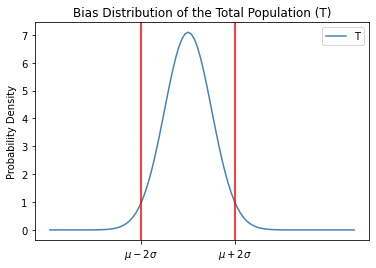

(-0.11071026131662905, 0.1143137797047576)

In [49]:
import numpy as np

# Sort the data in ascending order
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

total_pop = [b for _, b in biased_words]
x = np.linspace(np.min(total_pop), np.max(total_pop), 100)

# Calculate the probability density function (PDF) of the total_pop
mu = np.mean(total_pop)
sigma = np.std(total_pop)

pdf = norm.pdf(x, mu, sigma)

# Plot the curve
plt.plot(x, pdf, color='steelblue', label='T')
plt.axvline(x=mu - 2 * sigma, color = "red")
plt.axvline(x=mu + 2 * sigma, color = "red")

plt.title('Bias Distribution of the Total Population (T)')
# plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.xticks([mu - 2 * sigma, mu + 2 * sigma],[r"$\mu - 2\sigma$", r"$\mu + 2\sigma$"])
# Add a legend
plt.legend()

# Display the plot
plt.show()

mu-2*sigma, mu+2*sigma

In [50]:
import numpy as np


# Sort the data in ascending order
total_pop = [b for _, b in biased_words]
sorted_data = np.sort(total_pop)
# Calculate the quantiles for the three segments
quantiles = np.quantile(sorted_data, [0.08, 0.92])
# Divide the data based on the quantile thresholds
U2 = sorted_data[sorted_data <= quantiles[0]]
Un = sorted_data[(sorted_data > quantiles[0]) & (sorted_data < quantiles[1])]
U1 = sorted_data[sorted_data > quantiles[1]]
U2.mean(), U1.mean()

(-0.10640230886500361, 0.11101604741797053)

In [51]:
from scipy.stats import norm

class1 = []
class2 = []
classn = []

for ind in trange(len(data)):
    sample = wbias[ind]

    likelihood1 = np.sum((norm.logpdf(sample, np.mean(U1), np.std(U1))))
    likelihood2 = np.sum((norm.logpdf(sample, np.mean(U2), np.std(U2))))
    likelihood3 = np.sum((norm.logpdf(sample, np.mean(Un), np.std(Un))))

    # Compare likelihoods
    likelihoods = [likelihood1, likelihood2, likelihood3]
    population_labels = ['Population 0', 'Population 1', 'Population 2']
    best_fit_population = np.argmax(likelihoods)

    if abs(max(likelihoods)) < 0:
        classn.append((ind, max(likelihoods)))
        continue

    if best_fit_population == 2:
        classn.append((ind, max(likelihoods)))
    elif best_fit_population == 0 and max(likelihoods) :
        class1.append((ind, max(likelihoods)))
    else:
        class2.append((ind, max(likelihoods)))

100%|██████████| 20000/20000 [00:10<00:00, 1849.04it/s]


In [52]:
for s in data[data.index.isin([i for i, _ in class1])].text:
    print(s)

I love this coconut oil It tastes good and stays fresh in my cupboard in the container. It is exactly what I wanted and works beautifully for my family.
I've been using this product for years - you could say I'm addicted to it Local stores used to carry it but no more so I'm thrilled Amazon has it. Now if we could just get the 3lb size I'd be in heaven
I've heard this is a good food, but was shocked to see after chicken meal so many grains. I did not feed this to my dog. I'd rather pay more money for better quality food. All those fillers are unneeded. I expect such a highly regarded company to have better ingredients. I always look for by products but didn't think to even bother to check the next 4 ingredients. Highly disappointed.
This product is made in Singapore, so maybe the Chinese like.  I don't.  I had my wife taste it and she stated "that's horrible".  It calls for placing it in a cup and adding 250mm hot water.  Wonder how many ounces that is?
Pop Chips are the best chips I'v

In [53]:
for s in data[data.index.isin([i for i, _ in class2])].text:
    print(s)

Didn't taste like I thought it should.  Kinda awful. It went into the garbage.
this item was a real disappointment, it smells bad, tastes bad, looks bad, after preparing it looks very watery, portions are quite small, i threw the while thing out
Awful big disappointment......Nature's Path Organic Whole O's, Gluten Free Cereal, 11.5-Ounce Boxes (Pack of 6)....Did Not like the flavor the texture...just could eat these ...poured down the garbage disposal. I could not recommend these~
Muy buena calidad de alimento, a un preco muy economico. Tengo Gran danes y les encanta este producto, ademas de rendir muy buen tiempo.
I don't understand why this litter is called "clumping litter" - it does not clump.<br />Liquids are not clumped and the litter box becomes smelly.
This coffee tastes like dish water Smells horrible even before brewing, worse after brewingI can't beleive Amazon recommended this to me. Do not buy this coffee Enough said
The milk would not completely flow properly (slightly th

In [54]:
for s in data[data.index.isin([i for i, _ in classn])].text:
    print(s)

I hate making black icing at home, there's always an after taste from the food coloring and it ends up being a big mess. The Wilton tubes of black icing are great for frozen buttercream transfers when I decorate a birthday cake and much easier to handle.
I have tried several incarnations of this tea, both in bags and loose. Numi's loose version is cut bigger, which means less sediment, but I prefer Stash's smaller resealable bags.<br />I really like the sweet taste and often mix honeybush with rooibos.
Essentia water tastes great, and its price is in the same ball park as other good quality bottled water. However, stating that the 9.5 pH is good for you is completely devoid of any scientific substance. In fact, there are a lot of scientific studies that completely refute these claims. There's a page by a retired chemistry professor, who rips into the variety of similar "alkalanized" and "ionized" water marketing claims. Most importantly, his page contains a lot of links to University a